# 15. 프로젝트: 한국어 데이터로 챗봇 만들기

영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.




## 루브릭

|평가문항|	상세기준|
|:-------|:-------|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|**공백과 특수문자 처리, 토크나이징, 병렬데이터 구축**의 과정이 적절히 진행되었다.|
|2. 트랜스포머 모델을 구현하여 **한국어 챗봇 모델 학습을 정상적으로 진행**하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|
|3. 한국어 입력문장에 대해 **한국어로 답변하는 함수를 구현**하였다.|한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.|

## Step 1. 데이터 수집하기

한국어 챗봇 데이터는 **송영숙님이 공개한 챗봇 데이터**를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

[songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData%20.csv)

`wget으로 데이터 다운로드`
` wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv`

### 패키지 가져오기

In [1]:
# 필요한 패키지 가져오기
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 챗봇의 데이터 받아오기

In [2]:
# 챗봇의 데이터 받아오기
path_to_folder = os.getenv("HOME")+"/aiffel/songys_chatbot/"

path_to_data = os.path.join(path_to_folder, 'ChatbotData.csv')

chatbot = pd.read_csv(path_to_data)
chatbot

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


### Data description.

[인공데이터](https://github.com/songys/Chatbot_data)입니다.  
**일부 이별과 관련된 질문**에서 
  - 다음카페 "사랑보다 아름다운 실연( http://cafe116.daum.net/_c21_/home?grpid=1bld )"에서 
  - 자주 나오는 이야기들을 참고하여 제작하였습니다.   
  - 가령 "이별한 지 열흘(또는 100일) 되었어요"라는 질문에 
    - **챗봇이 위로한다는 취지로 답변을 작성**하였습니다.

1. 챗봇 트레이닝용 **문답 페어 11,876개**
2. 일상다반서 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

송영숙님의 데이터 설명서(Data description)에서는 문답 페어가 11,876개라고 했는데 chatbot 데이터의 shape는 (11823, 3)으로 53개의 데이터가 모자란다.  
챗봇 데이터가 그 사이에 수정되었을까?

## Step 2. 데이터 전처리하기

영어 데이터와는 전혀 다른 데이터인 만큼 
  - 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 
  - **전체적으로는 다른 전처리를 수행**해야 할 수도 있습니다.

### 데이터 전처리

In [3]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
  
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "하루가 또 가네요." => "하루가 또 가네요 ."와 같이
    # "가네요"와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)   # 4개의 구두점(! ? , .)이 있는 경우에 구두점 앞에 공백을 만듦
    sentence = re.sub(r'[" "]+', " ", sentence)         # 공백 1개 이상인 경우에 공백 1개로 만듦
  
    # (ㄱ-힣, a-z, A-Z, 0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^ㄱ-힣a-zA-Z0-9?.!,]+", " ", sentence)  
    sentence = sentence.strip()
    return sentence

* 한국어 검출 : "ㄱ~힣"
* 숫자 검출 : "0~9"

In [4]:
# 사용할 샘플의 최대 개수 (챗봇 트레이닝용 문답 페어 갯수)
MAX_SAMPLES = chatbot.shape[0]
print(MAX_SAMPLES)

11823


* 데이터의 갯수가 충분이 크다면 학습시간을 고려하여 최대 갯수를 한정하겠지만 그렇지 않은 경우에는 데이터 전체를 학습에 사용한다.

In [5]:
# 원본 데이터 5줄 확인
def printLines(file, n=5):
    with open(file, 'r') as datafile:
        lines = datafile.readlines()
    for line in lines[1:n]:
        print(line)
#         conversation = line.split(',')
#         print(preprocess_sentence(conversation[0]))    # 1번째 컬럼(Q)
#         print(preprocess_sentence(conversation[1]))    # 2번째 컬럼(A)
#         print(preprocess_sentence(conversation[2]))    # 3번째 컬럼(Label)

printLines(path_to_data)

12시 땡!,하루가 또 가네요.,0

1지망 학교 떨어졌어,위로해 드립니다.,0

3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0

3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0



* 하나의 행의 데이터는 콤마(,)로 구분됨
* 'rb' 옵션으로 파일을 열면, 하나의 행은 `\r\n` 으로 끝남
  - `b'12\xec\x8b\x9c \xeb\x95\xa1!,\xed\x95\x98\xeb\xa3\xa8\xea\xb0\x80 \xeb\x98\x90 \xea\xb0\x80\xeb\x84\xa4\xec\x9a\x94.,0\r\n'`

### 데이터 쌍 만들기

In [6]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  
    inputs, outputs, labels = [], [], []
    
    with open(path_to_data, 'r') as file:
        lines = file.readlines()
  
    for line in lines[1:]:
        conversation = line.replace('\r\n', '').split(',')
  
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(preprocess_sentence(conversation[0]))   # 1번째 컬럼(Q)
        outputs.append(preprocess_sentence(conversation[1]))  # 2번째 컬럼(A)
        labels.append(preprocess_sentence(conversation[2]))   # 3번째 컬럼(Label)

        if len(inputs) >= MAX_SAMPLES:
            return inputs, outputs, labels

    return inputs, outputs, labels

In [7]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장
questions, answers, labels = load_conversations()

### 어텐션

#### 포지셔널 인코딩 레이어
단어가 문장의 몇 번째 어순으로 입력되었는지를 모델에 추가로 알려 주기 위해 (위치 정보를 가진 백터)

In [8]:
# 포지셔널 인코딩 레이어 구하는 클래스
class PositionalEncoding(tf.keras.layers.Layer):
  
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
  
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
  
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

* tf.pow()
* tf.cast()
* tf.range()
* tf.math.sin()
* tf.math.cos()
* tf.concat()
* tf.newaxis

#### 스케일드 닷 프로덕트 어텐션

단어들 간의 유사도를 구하는 함수

In [9]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    """어텐션 가중치를 계산."""
    matmul_qk = tf.matmul(query, key, transpose_b=True)
  
    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
  
    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)
  
    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)
  
    output = tf.matmul(attention_weights, value)
  
    return output

* tf.matmul()
* tf.math.sqrt()

#### 멀티 헤드 어텐션
어텐션을 병렬로 수행하는 함수

In [10]:
# 어텐션을 병렬로 수행하는 멀티 헤드 어텐션 함수
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
    
        self.depth = d_model // self.num_heads
    
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
    
        self.dense = tf.keras.layers.Dense(units=d_model)
      
    
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, 
                            shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
  
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]
    
        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
    
        # 병렬 연산을 위한 머리를 여러 개 만듭니다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
    
        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    
        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))
    
        # final linear layer
        outputs = self.dense(concat_attention)
    
        return outputs

* tf.reshape()
* tf.transpose()
* self.split_heads()

### 마스킹 

#### 패딩 마스킹

In [11]:
#  패딩 마스킹(Padding Masking)을 구현한 함수
def create_padding_mask(x):
    # 숫자 0인 위치 체크
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]    # 숫자가 0인 부분을 체크한 벡터를 리턴

#### 룩 어헤드 마스킹
자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법  
Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹

In [12]:
# 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)을 구현한 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    
    return tf.maximum(look_ahead_mask, padding_mask)

* tf.linalg.band_part()
* tf.ones()

### 인코더 & 디코더

#### 인코더 하나의 레이어
2개의 서브 층(sublayer) 으로 구성

In [13]:
# 인코더 하나의 레이어를 구현한 함수
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
  
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
  
    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
  
    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  
    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
  
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

* tf.keras.layers.LayerNormalization()

#### 트랜스포머의 인코더
임베딩 층(Embedding layer)과 포지셔널 인코딩(Positional Encoding)을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓아서 완성

In [14]:
# 트랜스포머의 인코더 함수
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    # Functional Model 사용 (2개의 input)
    inputs = tf.keras.Input(shape=(None,), name="inputs")
  
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
  
    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(units=units,
                                d_model=d_model,
                                num_heads=num_heads,
                                dropout=dropout,
                                name="encoder_layer_{}".format(i),
                                )([outputs, padding_mask])
  
    return tf.keras.Model(inputs=[inputs, padding_mask], 
                          outputs=outputs, 
                          name=name)


#### 디코더 하나의 레이어
 세 개의 서브 층(sublayer)으로 구성

In [15]:
# 디코더 하나의 레이어를 구현한 함수
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), 
                            name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), 
                                 name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), 
                                     name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), 
                                  name='padding_mask')
  
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, 
                                    num_heads, 
                                    name="attention_1")(inputs={'query': inputs,
                                                                'key': inputs,
                                                                'value': inputs,
                                                                'mask': look_ahead_mask
                                                                })
  
    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
  
    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, 
                                    num_heads, 
                                    name="attention_2")(inputs={'query': attention1,
                                                                'key': enc_outputs,
                                                                'value': enc_outputs,
                                                                'mask': padding_mask
                                                                })
  
    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
  
    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  
    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
  
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs=outputs,
                          name=name)

* tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

#### 트랜스포머의 디코더
임베딩 층(Embedding layer)과 포지셔널 인코딩(Positional Encoding)을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아서 완성

In [16]:
# 트랜스포머의 디코더 함수
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
  
    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  
    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
  
    # num_layers만큼 쌓아올린 디코더의 층
    for i in range(num_layers):
        outputs = decoder_layer(units=units,
                                d_model=d_model,
                                num_heads=num_heads,
                                dropout=dropout,
                                name='decoder_layer_{}'.format(i),
                                )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
  
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs=outputs,
                          name=name)


## Step 3. SubwordTextEncoder 사용하기

한국어 데이터는 **형태소 분석기를 사용하여 토크나이징을 해야 한다**고 많은 분이 알고 있습니다.   
하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 **내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용**해보세요.



### 병렬 데이터 전처리하기

#### 1. 단어장(Vocabulary) 만들기

In [17]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.2.0 이하)
# tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# (주의) Tensorflow 2.3.0 이상의 버전에서는 아래 주석의 코드를 대신 실행해 주세요. 
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)


In [18]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [19]:
# 시작 토큰과 종료 토큰에 부여된 정수를 출력해봅시다.
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8147]
END_TOKEN의 번호 : [8148]


각각 8,147과 8,148라는 점에서 현재 단어장의 크기가 8,147(0번부터 8,146번)이라는 의미입니다.

In [20]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8149


#### 2. 챗봇 데이터 길이 분포
* [참고: 6)패딩 부분](https://wikidocs.net/44249)

질문의 최대 길이 : 57
질문의 평균 길이 : 13.190645352279455


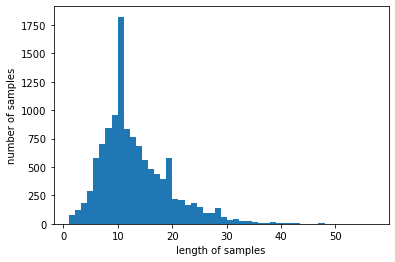

In [21]:
# questions 데이터의 길이 분포
print('질문의 최대 길이 :',max(len(q) for q in questions))
print('질문의 평균 길이 :',sum(map(len, questions))/len(questions))

plt.hist([len(s) for s in questions], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

답변의 최대 길이 : 72
답변의 평균 길이 : 15.933434830415292


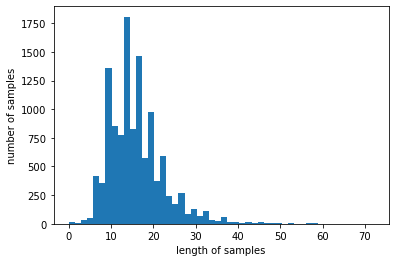

In [22]:
# answers 데이터의 길이 분포
print('답변의 최대 길이 :',max(len(a) for a in answers))
print('답변의 평균 길이 :',sum(map(len, answers))/len(answers))

plt.hist([len(s) for s in answers], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [23]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
          if(len(s) <= max_len):
                cnt = cnt + 1
    name = nested_list      
    print(f'전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {(cnt / len(nested_list))*100}')

In [24]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 30

below_threshold_len(MAX_LENGTH, questions)
below_threshold_len(MAX_LENGTH, answers)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 98.24917533620908
전체 샘플 중 길이가 30 이하인 샘플의 비율: 96.37993741013278


샘플 최대 길이를 30으로 하였을 경우 질문의 문장은 98% 이상이 포함된다.

#### 3. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [25]:
# 임의의 33번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 33번째 질문 샘플: {}'.format(tokenizer.encode(questions[32])))
print('정수 인코딩 후의 33번째 답변 샘플: {}'.format(tokenizer.encode(answers[32])))

정수 인코딩 후의 33번째 질문 샘플: [7851, 1148, 1051, 2]
정수 인코딩 후의 33번째 답변 샘플: [1080, 3158, 641, 263, 877, 618, 284, 1]


In [26]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    
        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
      
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, 
                                                                     maxlen=MAX_LENGTH, 
                                                                     padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, 
                                                                      maxlen=MAX_LENGTH, 
                                                                      padding='post')
    
    return tokenized_inputs, tokenized_outputs


In [27]:
# 필터링 후에 단어장의 크기와 샘플의 갯수 확인
questions, answers = tokenize_and_filter(questions, answers)
                                         
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8149
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


필터링 전과 후의 샘플 개수가 11823으로 동일하다.

#### 4. 교사 강요(Teacher Forcing) 사용하기

모델이 t 시점에서 예측한 값을 t+1 시점에 입력으로 사용하지 않고,   
t 시점의 레이블. 즉, 실제 알고있는 정답을 t+1 시점의 입력으로 사용

In [28]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


## Step 4. 모델 구성하기

위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.



In [29]:
# 트랜스포머 함수
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
  
    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, 
                                              output_shape=(1, 1, None),
                                              name='enc_padding_mask')(inputs)
  
    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask,
                                             output_shape=(1, None, None),
                                             name='look_ahead_mask')(dec_inputs)
  
    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, 
                                              output_shape=(1, 1, None),
                                              name='dec_padding_mask')(inputs)
  
    # 인코더
    enc_outputs = encoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,
                          )(inputs=[inputs, enc_padding_mask])
  
    # 디코더
    dec_outputs = decoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,
                          )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
  
    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
  
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

#### 1. 모델 생성

In [30]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2  # 인코더와 디코더의 층의 개수
D_MODEL = 256   # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8   # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512     # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1   # 드롭아웃의 비율

model = transformer(vocab_size=VOCAB_SIZE,
                    num_layers=NUM_LAYERS,
                    units=UNITS,
                    d_model=D_MODEL,
                    num_heads=NUM_HEADS,
                    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    3140352     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

"Connected to" 컬럼은 처음 보는데...어떻게 해석해야하나...?   

#### 2. 손실 함수(Loss function)

In [31]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                         reduction='none')(y_true, y_pred)
  
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
  
    return tf.reduce_mean(loss)

#### 3. 커스텀된 학습률(Learning rate)

$$\mathbf{{\color{Red} {lrate = d_{model}^{-0.5} \cdot  min \left (step\_num^{-0.5}, ~~ step\_num \cdot  warmup\_steps^{-1.5}   \right )}}}$$

In [32]:
# 커스텀 학습률 스케줄링(Custom Learning rate Scheduling) 
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
    
        self.warmup_steps = warmup_steps
    
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)             # rsqrt: reciprocal of square root
        arg2 = step * (self.warmup_steps**-1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    

#### 4. 모델 컴파일
손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일

In [33]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, 
                                     beta_1=0.9, 
                                     beta_2=0.98, 
                                     epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


model.compile(optimizer=optimizer, 
              loss=loss_function, 
              metrics=[accuracy])


#### 5. 훈련하기

In [34]:
EPOCHS = 20   # 20 --> 100

model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 10s 53ms/step - loss: 1.9313 - accuracy: 0.0328
Epoch 2/20
185/185 [==============================] - 10s 53ms/step - loss: 1.5680 - accuracy: 0.0662
Epoch 3/20
185/185 [==============================] - 10s 56ms/step - loss: 1.3435 - accuracy: 0.0677
Epoch 4/20
185/185 [==============================] - 11s 61ms/step - loss: 1.2438 - accuracy: 0.0725
Epoch 5/20
185/185 [==============================] - 11s 59ms/step - loss: 1.1671 - accuracy: 0.0768
Epoch 6/20
185/185 [==============================] - 10s 54ms/step - loss: 1.0877 - accuracy: 0.0823
Epoch 7/20
185/185 [==============================] - 10s 54ms/step - loss: 0.9994 - accuracy: 0.0904
Epoch 8/20
185/185 [==============================] - 10s 54ms/step - loss: 0.9029 - accuracy: 0.1008
Epoch 9/20
185/185 [==============================] - 10s 55ms/step - loss: 0.7979 - accuracy: 0.1124
Epoch 10/20
185/185 [==============================] - 10s 54ms/step - loss: 0.689

## Step 5. 모델 평가하기

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다. 

In [35]:
# 디코더 예측(inference) 함수
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
  
    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
  
    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)
  
    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
    
        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
    
        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
    
    return tf.squeeze(output_sequence, axis=0)

In [36]:
# 챗봇의 대답을 얻는 함수
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)
  
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])
  
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))
  
    return predicted_sentence


In [37]:
# 임의의 문장으로부터 챗봇의 대답

sentence_generation('나이 차이가 좀 있는데 고민입니다.')

입력 : 나이 차이가 좀 있는데 고민입니다.
출력 : 나이 차이는 극복할 수 있어요 .


'나이 차이는 극복할 수 있어요 .'

입력 : 나이 차이가 좀 있는데 고민입니다.  
출력20 : 나이 차이는 극복할 수 있어요 .  
출력100 : 나이 차이는 중요하지 않아요 .  
출력20 : 나이 차이는 극복할 수 있어요 .  

In [38]:
# 임의의 문장으로부터 챗봇의 대답

sentence_generation("자주 만나기 힘드네요!")

입력 : 자주 만나기 힘드네요!
출력 : 덜 힘들었으면 좋겠어요 .


'덜 힘들었으면 좋겠어요 .'

입력 : 자주 만나기 힘드네요`!`  
출력20 : 성격이 안 맞나봐요 .  
출력100 : 좋은 추억만 간직하세요 .  
출력20 : 덜 힘들었으면 좋겠어요 .

In [39]:
# 임의의 문장으로부터 챗봇의 대답

sentence_generation("늦은 밤에 보자고 하는데...")

입력 : 늦은 밤에 보자고 하는데...
출력 : 그냥 얼굴 보면 설레요 .


'그냥 얼굴 보면 설레요 .'

입력 : 늦은 밤에 보자고 하는데...  
출력20 : 당신의 사랑이 생길 거예요 .  
출력100 : 너무 신경 곤두세우지 마세요 .  
출력20 : 그냥 얼굴 보면 설레요 .

In [40]:
# 임의의 문장으로부터 챗봇의 대답

sentence_generation("친구와 같이 술을 먹자고 하네")

입력 : 친구와 같이 술을 먹자고 하네
출력 : 연락 확실하게 끊으세요 .


'연락 확실하게 끊으세요 .'

입력 : 친구와 같이 술을 먹자고 하네  
출력20 : 함께 충분한 대화를 하고 상담을 받아보는 게 좋겠어요 .  
출력100 : 한 번 말해보는게 좋겠어요 .  
출력20 : 연락 확실하게 끊으세요 .  

In [41]:
# 임의의 문장으로부터 챗봇의 대답

sentence_generation("너무 피곤하다")

입력 : 너무 피곤하다
출력 : 자신의 인생을 사세요 .


'자신의 인생을 사세요 .'

입력 : 너무 피곤하다  
출력20 : 너무 자책하지 마세요 .  
출력100 : 마음이 따뜻할 것 같아요 .  
출력20 : 자신의 인생을 사세요 .

## 회고

* 챗봇의 대답을 듣고 훌륭한 대화상대가 생긴 것 같은 기분이 들었다.
* 에폭을 증가시켜 훈련한 경우에 동일한 질문에 대해서 다른 대답이 나왔다. 그런데 좀 어색하다.
* "Connected to" 컬럼은 처음 보는데...어떻게 해석해야하나...?

## 끝